# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

**Описание данных**

Признаки  
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя  

Целевой признак  
- Price — цена (евро)

**План работы**  
1. Изучим и подготовим данные(обработаем пропуски, дубликаты, преобразуем категориальные признаки в численные);
2. Разделим данные на три выборки;
3. Исследуем модели регрессии: линейная регрессия, случайный лес, LightGBM;
4. Подберем лучшие гиперпараметры;
5. Сравним время обучения, время предсказания и качесвто разным моделей;
5. Проверим лучшую модель на тестовой выборке.

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.dummy import DummyRegressor

from lightgbm import LGBMRegressor

from fast_ml.model_development import train_valid_test_split

from datetime import datetime

from tqdm import tqdm

## Подготовка данных

In [2]:
dateparse = lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S')

df = pd.read_csv('autos.csv', parse_dates=['DateCrawled', 'DateCreated', 'LastSeen'], 
                 date_parser=dateparse)
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   Price              354369 non-null  int64         
 2   VehicleType        316879 non-null  object        
 3   RegistrationYear   354369 non-null  int64         
 4   Gearbox            334536 non-null  object        
 5   Power              354369 non-null  int64         
 6   Model              334664 non-null  object        
 7   Kilometer          354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  int64         
 9   FuelType           321474 non-null  object        
 10  Brand              354369 non-null  object        
 11  Repaired           283215 non-null  object        
 12  DateCreated        354369 non-null  datetime64[ns]
 13  NumberOfPictures   354369 non-null  int64   

In [4]:
df.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

In [5]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Мы видим что в столбцах `Price`, `RegistrationYear`, `Power` присутствуют аномальные значения и совсем отсутствуют фотографии в анкетах.

### Ознакомимся с данными с помощью графиков.

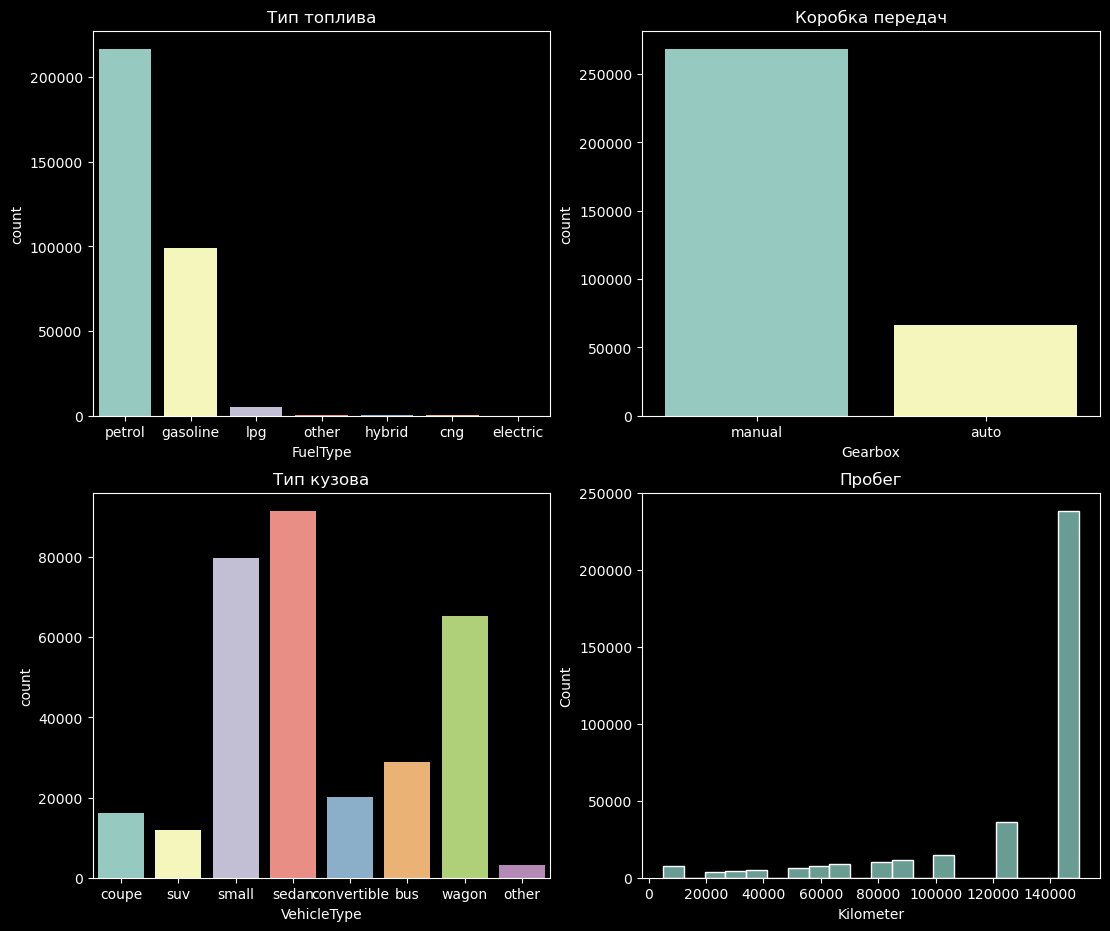

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(13, 11))
sns.countplot(df, x='FuelType', ax=axes[0, 0]);
sns.countplot(df, x='Gearbox', ax=axes[0, 1]);
sns.countplot(df, x='VehicleType', ax=axes[1, 0]);
sns.histplot(df, x='Kilometer', bins=20, ax=axes[1, 1]);

axes[0, 0].set_title('Тип топлива', fontsize=12);
axes[0, 1].set_title('Коробка передач', fontsize=12);
axes[1, 0].set_title('Тип кузова', fontsize=12);
axes[1, 1].set_title('Пробег', fontsize=12);

### Дата регистрации автомобиля

Рассмотрим столбец `RegistrationYear`

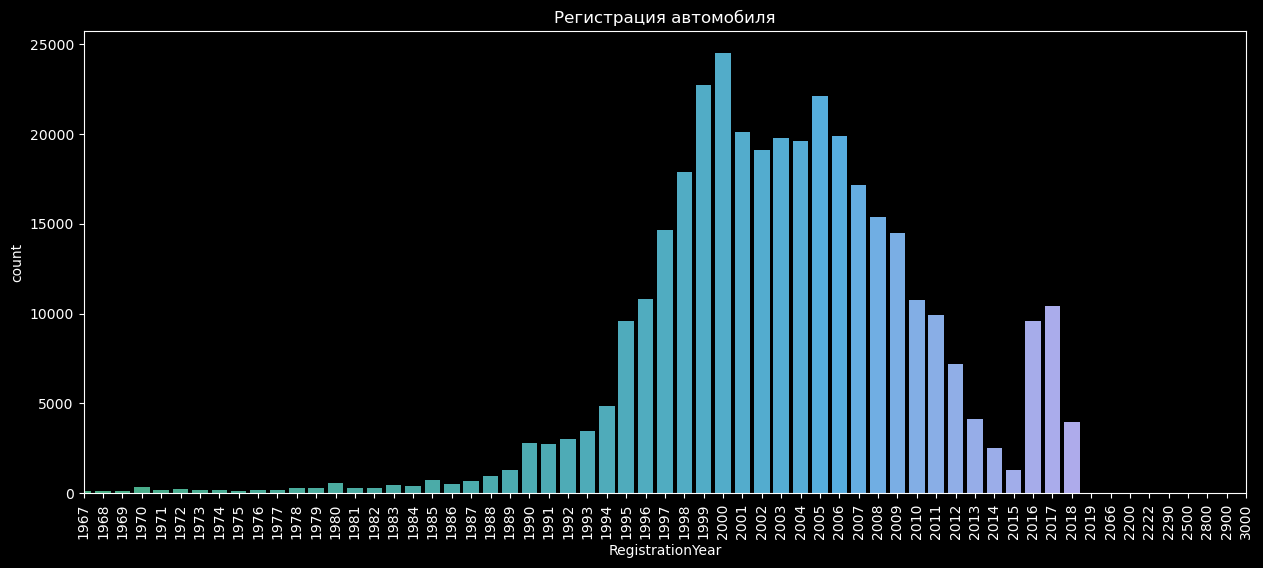

In [7]:
plt.figure(figsize=(15, 6))
sns.countplot(x=df['RegistrationYear']);
plt.xlim(60, 120);
plt.xticks(rotation=90);
plt.title('Регистрация автомобиля');

In [8]:
df['RegistrationYear'].describe()

count    354369.000000
mean       2004.234448
std          90.227958
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: RegistrationYear, dtype: float64

In [9]:
df.DateCreated.max()  # дата последней анкеты

Timestamp('2016-04-07 00:00:00')

Дата регистрации машины не может быть позже даты создания анкеты и раньше первого созданного автомобиля в 1885 году.

Создадим столбцы с годом и месяцем регистрации анкеты и регистрации автомобиля в формате "200405" где первые 4 цифры год, последние 2 - месяц.

In [10]:
df['Reg_auto'] = df['RegistrationYear'] * 100 + df['RegistrationMonth']  # регистрация автомобиля
df['Reg_form'] = df['DateCreated'].dt.year * 100 + df['DateCreated'].dt.month  # регистрация анкеты
df.head(2)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen,Reg_auto,Reg_form
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57,199300,201603
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50,201105,201603


In [11]:
df = df.query('RegistrationYear > 1885 & Reg_auto <= Reg_form')

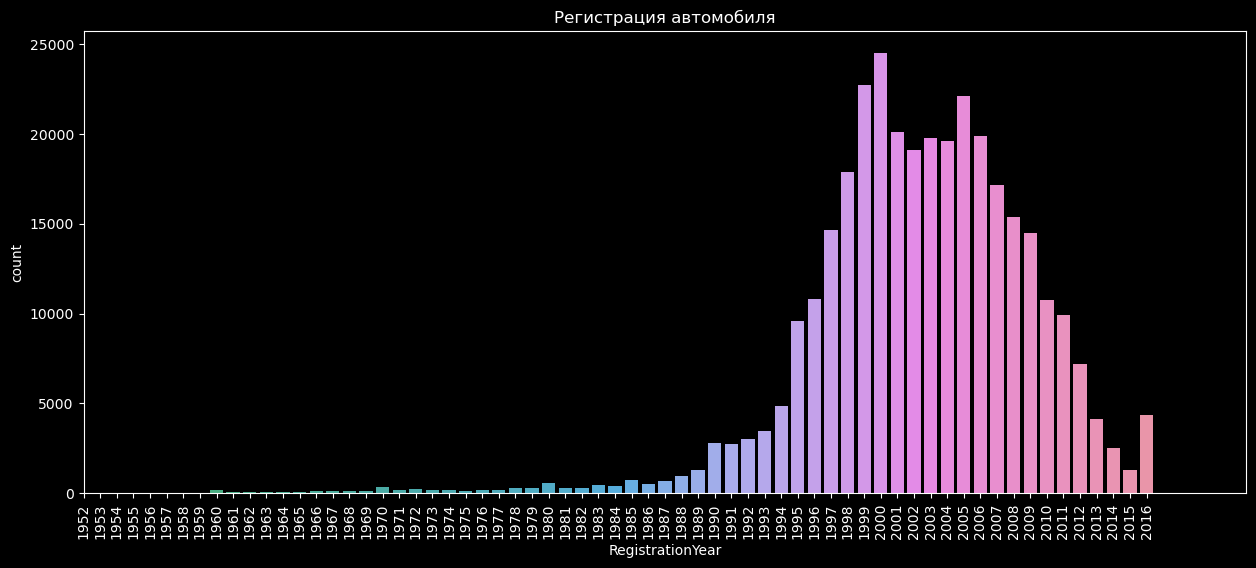

In [12]:
plt.figure(figsize=(15, 6))
sns.countplot(x=df['RegistrationYear']);
plt.xlim(30, 100);
plt.xticks(rotation=90);
plt.title('Регистрация автомобиля');

### Стоимость автомобиля

Рассмотрим столбец `Price`

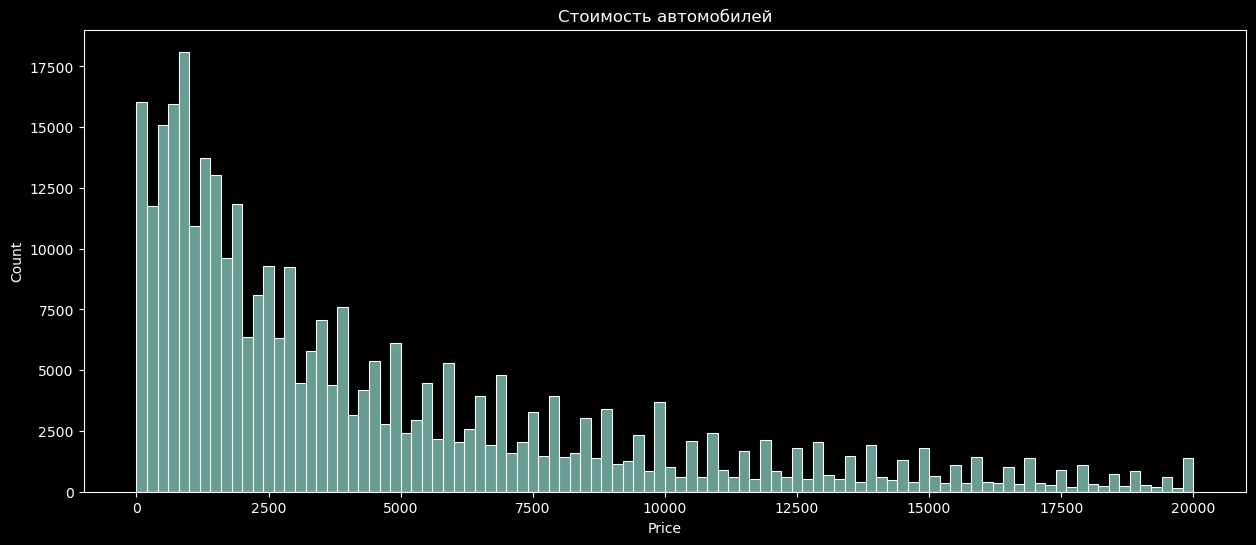

In [13]:
plt.figure(figsize=(15, 6))
sns.histplot(df['Price'], bins=100);
plt.title('Стоимость автомобилей');

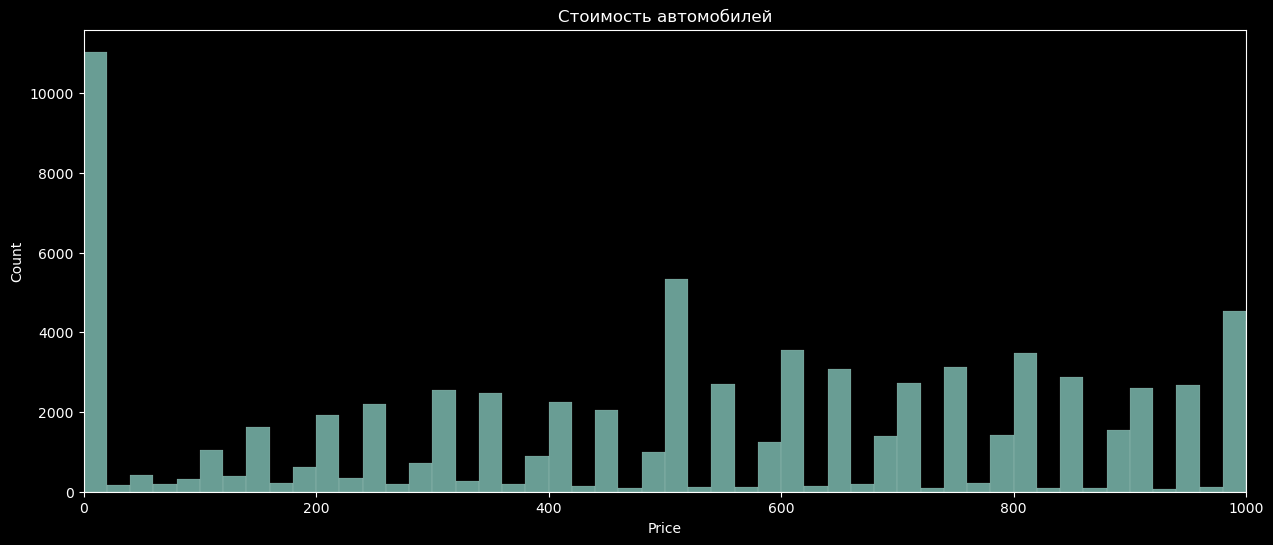

In [14]:
plt.figure(figsize=(15, 6))
sns.histplot(df['Price'], bins=1000)
plt.xlim(0, 1000);
plt.title('Стоимость автомобилей');

In [15]:
df[df['Price'] == 0]['Price'].count()

9746

In [16]:
df.Price.describe()

count    334543.000000
mean       4504.837833
std        4558.230751
min           0.000000
25%        1100.000000
50%        2800.000000
75%        6500.000000
max       20000.000000
Name: Price, dtype: float64

Удалим автомобили, стоимость которых менее 1100 евро - ниже 1 квартиля.

In [17]:
df = df.query('Price >= 1100')
df.Price.describe()

count    252074.000000
mean       5802.511052
std        4550.594970
min        1100.000000
25%        2249.000000
50%        4200.000000
75%        8000.000000
max       20000.000000
Name: Price, dtype: float64

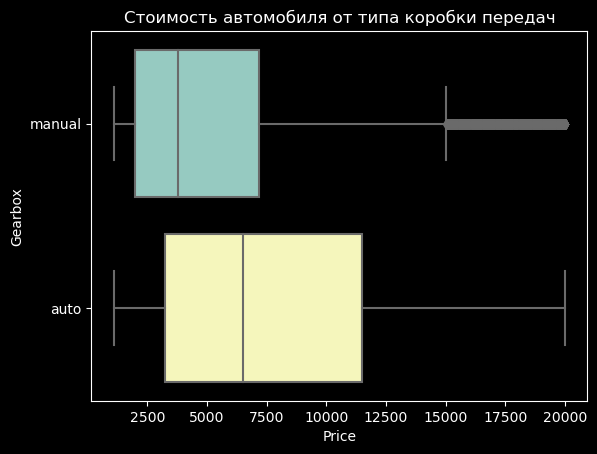

In [18]:
sns.boxplot(x='Price', y='Gearbox', data=df)
plt.title('Стоимость автомобиля от типа коробки передач');

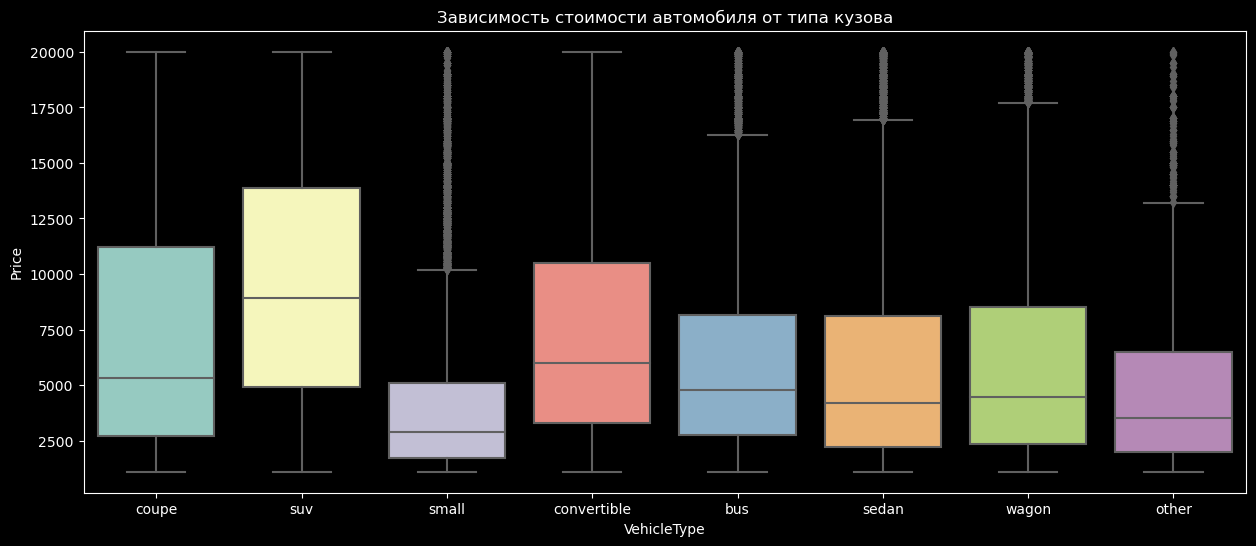

In [19]:
plt.figure(figsize=(15, 6))
sns.boxplot(x='VehicleType', y='Price', data = df);
plt.title('Зависимость стоимости автомобиля от типа кузова');

### Тип кузова, Коробка передач, Тип топлива, Модель, Ремонт

Проанализируем пропуски на графиках.

In [20]:
df.isna().sum()

DateCrawled              0
Price                    0
VehicleType           6448
RegistrationYear         0
Gearbox               8463
Power                    0
Model                 9285
Kilometer                0
RegistrationMonth        0
FuelType             11608
Brand                    0
Repaired             34920
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
Reg_auto                 0
Reg_form                 0
dtype: int64

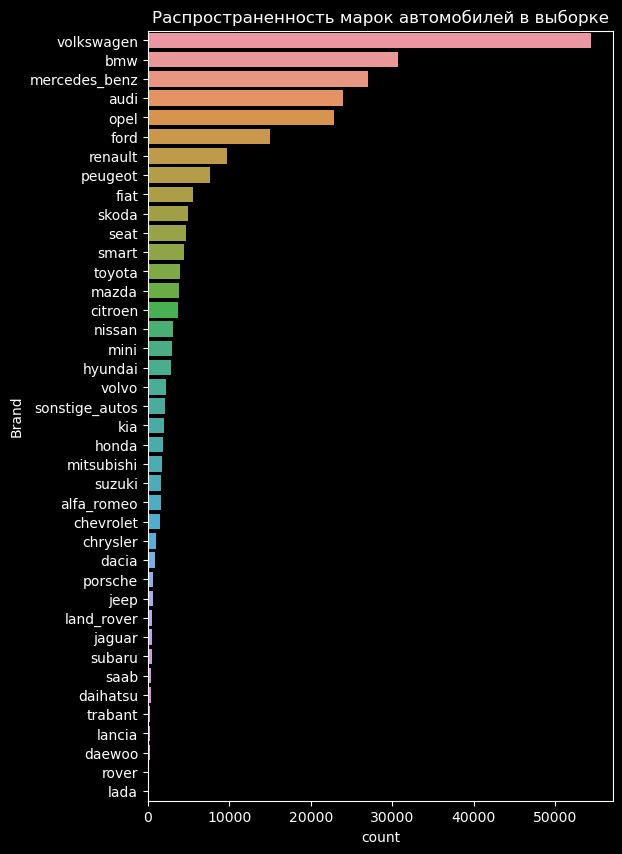

In [21]:
plt.figure(figsize=(6, 10))
sns.countplot(y='Brand', data = df, order=df['Brand'].value_counts().index)
plt.title('Распространенность марок автомобилей в выборке');

In [22]:
def countplot(feature, data, title):
    plt.figure(figsize=(15, 6))
    sns.countplot(x='Brand', hue=feature, data = data)
    plt.xticks(rotation=90);
    plt.title(title);

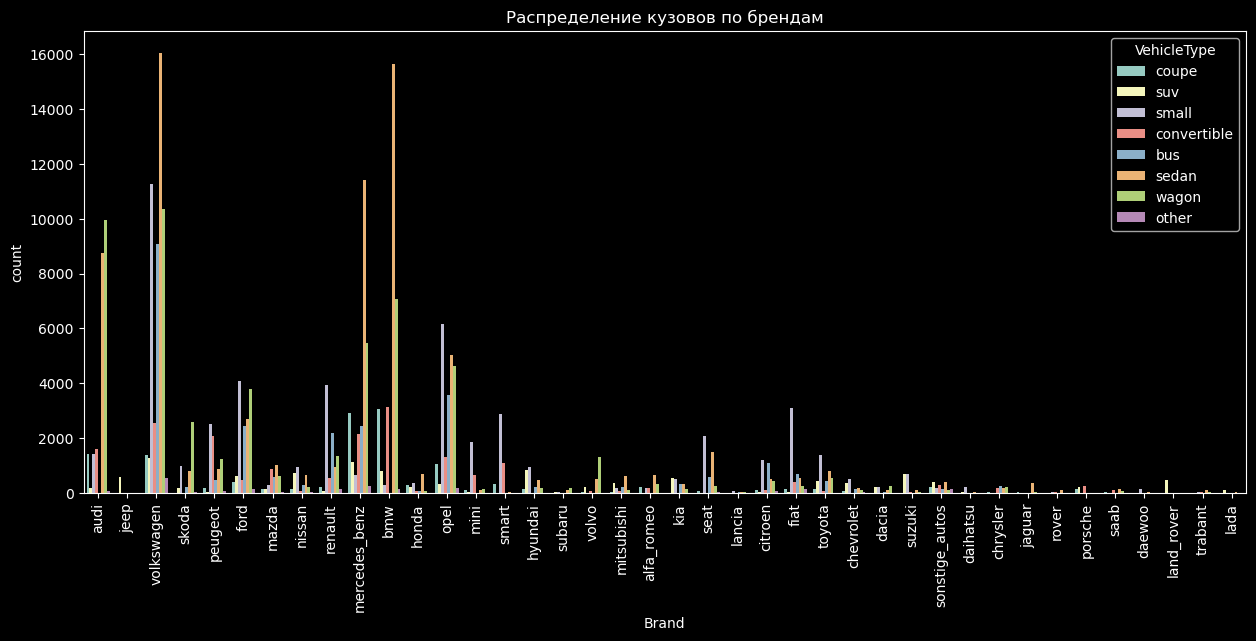

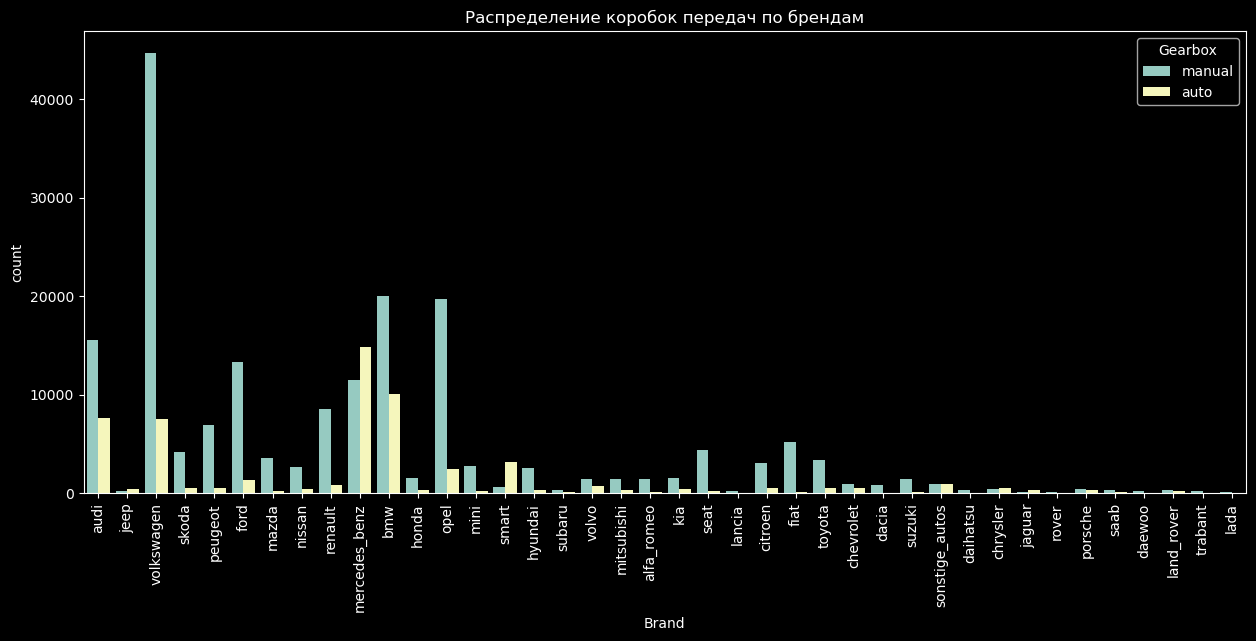

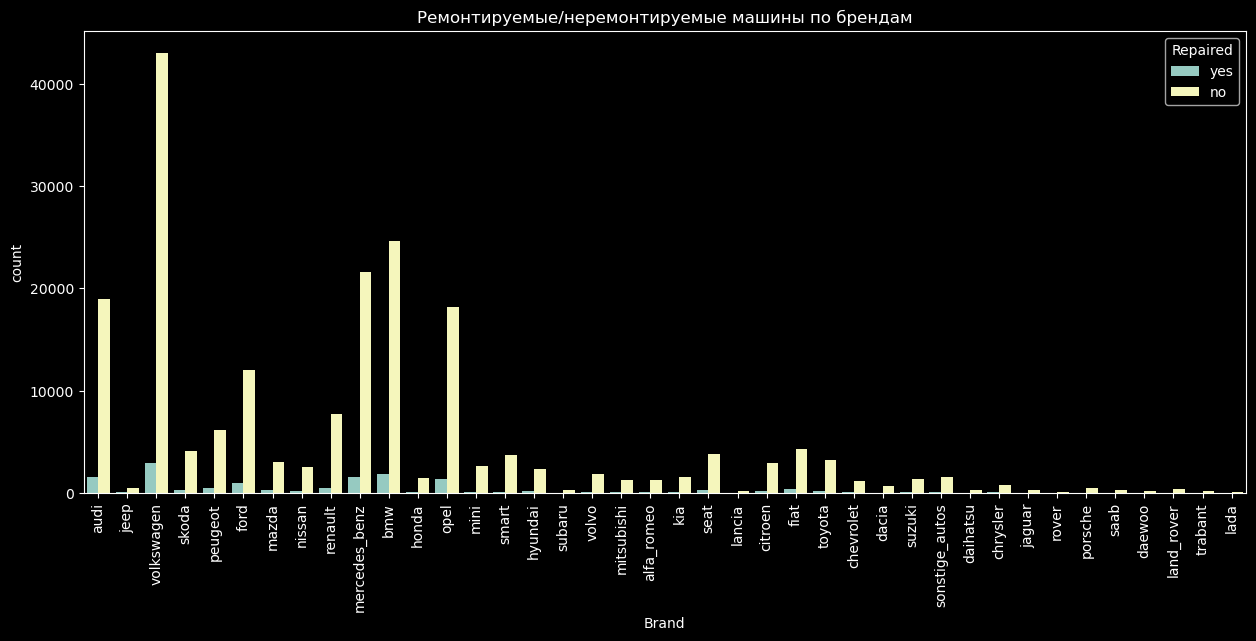

In [23]:
countplot('VehicleType', df, 'Распределение кузовов по брендам')
countplot('Gearbox', df, 'Распределение коробок передач по брендам')
countplot('Repaired', df, 'Ремонтируемые/неремонтируемые машины по брендам')

По последнему графику видно, что название сервиса «Не бит, не крашен» соответствует представленным машинам. Рассмотрим, как изменится соотношение для старых машин.

In [24]:
df_old_cars = df.loc[df['RegistrationYear'] < 1980]  # возьмем старые машины

In [25]:
df_old_cars.shape[0]

2768

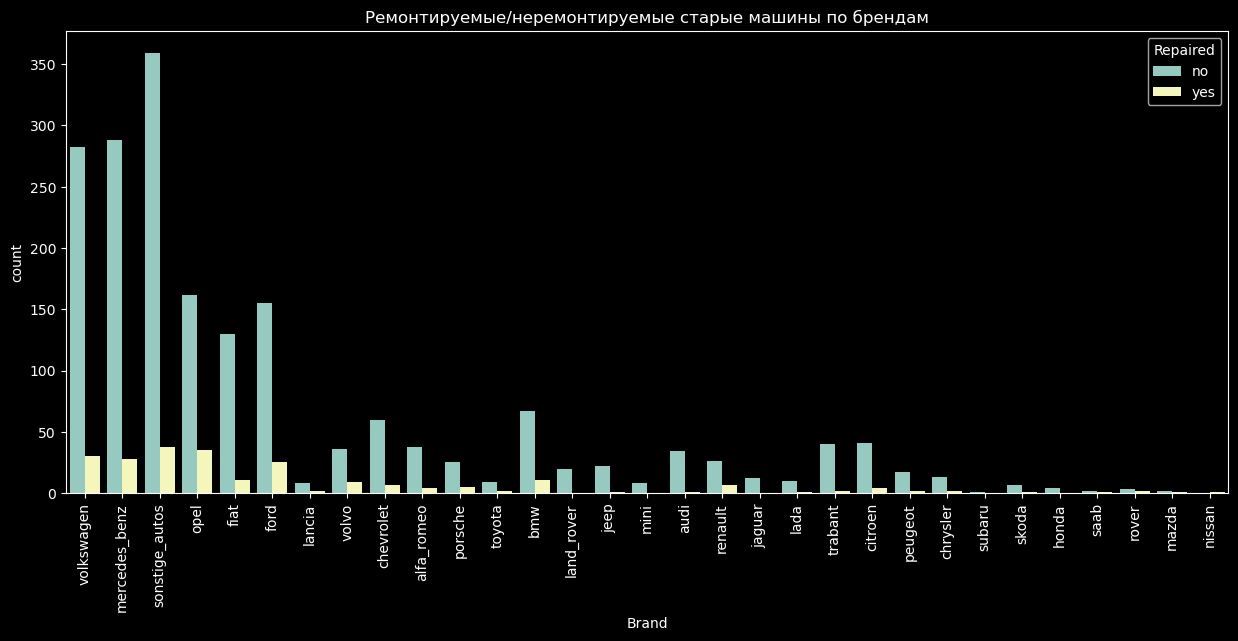

In [26]:
countplot('Repaired', df_old_cars, 'Ремонтируемые/неремонтируемые старые машины по брендам')

Старых машин не так много. И даже среде них соотношение сохраняется.

Мы видим, что у разных брендов популярны рязные типы кузовов, коробки передач, типы топлива. Заменим пропуски самыми распространенными значениями признака для каждого бренда.

In [27]:
def get_value_by_brand(feature):
    df[feature] = df[feature].fillna(df.groupby(by=['Brand'])[feature]
                                                 .transform(lambda x: x.value_counts().idxmax()))

In [28]:
feature_list = ['VehicleType', 'Gearbox', 'FuelType', 'Repaired']
for i in feature_list:
        get_value_by_brand(i)

Заменим неизвестные модели на `other`

In [29]:
df['Model'] = df['Model'].fillna('other')

In [30]:
df.isna().sum()

DateCrawled          0
Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
Repaired             0
DateCreated          0
NumberOfPictures     0
PostalCode           0
LastSeen             0
Reg_auto             0
Reg_form             0
dtype: int64

### Мощность двигателя

Рассмотрим колонку мощности двигателя.

In [31]:
df['Power'].describe()

count    252074.000000
mean        123.486409
std         191.633324
min           0.000000
25%          80.000000
50%         116.000000
75%         150.000000
max       20000.000000
Name: Power, dtype: float64

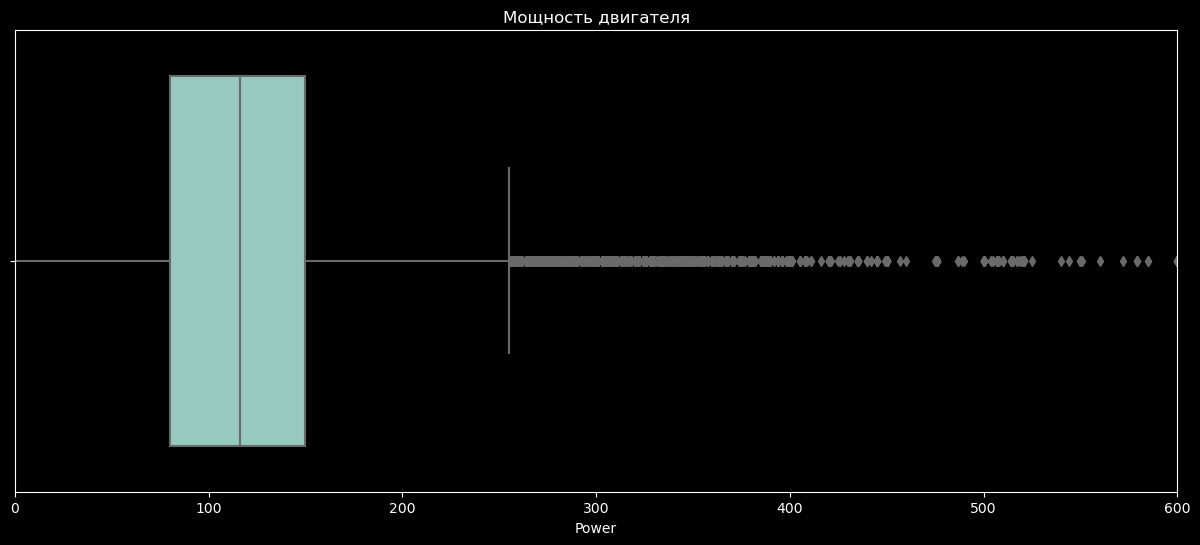

In [34]:
plt.figure(figsize=(15, 6))
sns.boxplot(df, x='Power');
plt.xlim(0, 600);
plt.title('Мощность двигателя');

Присутствуют аномальные значения. 

In [35]:
df[df['Power'] > 500]['Power'].count()

276

Больше 500 л. с. только у болидов. Удалим эти значения.

In [36]:
df = df.query('Power < 500')

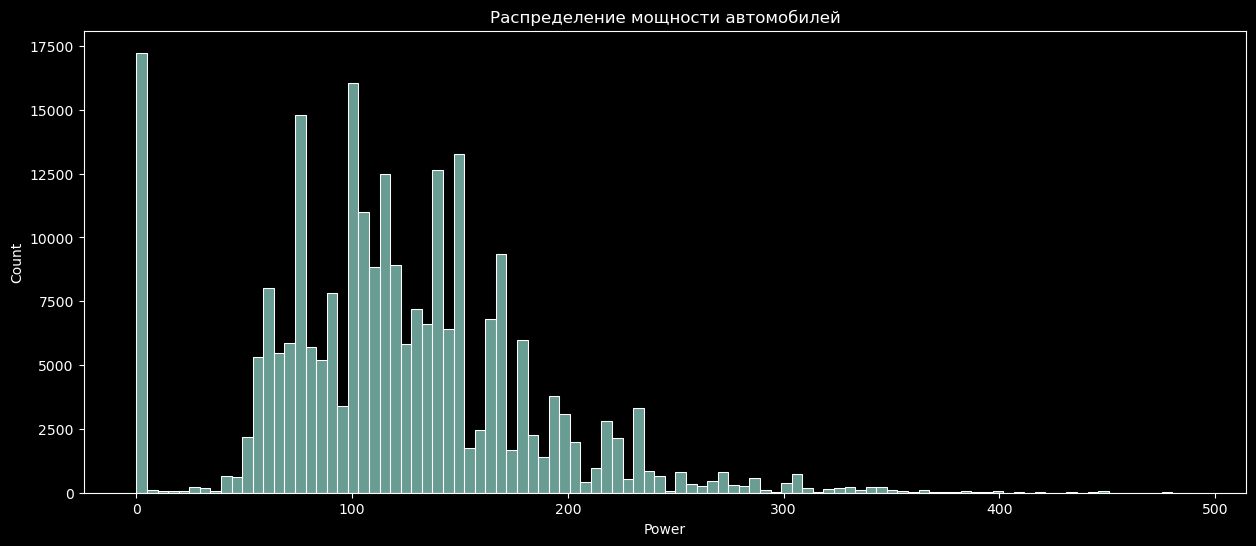

In [37]:
plt.figure(figsize=(15, 6))
sns.histplot(df['Power'], bins=100);
plt.title('Распределение мощности автомобилей');

Около 35 тыс. объявлений с нулевым значением мощности двигателя - это 10% нашей выборки. Восстановим значения по медианной мощности модели автомобиля.

In [38]:
df['Power'] = df.groupby('Model')['Power'].apply(lambda x: x.mask(x.eq(0)).fillna(x.median()))

In [39]:
df.isna().sum()

DateCrawled          0
Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
Repaired             0
DateCreated          0
NumberOfPictures     0
PostalCode           0
LastSeen             0
Reg_auto             0
Reg_form             0
dtype: int64

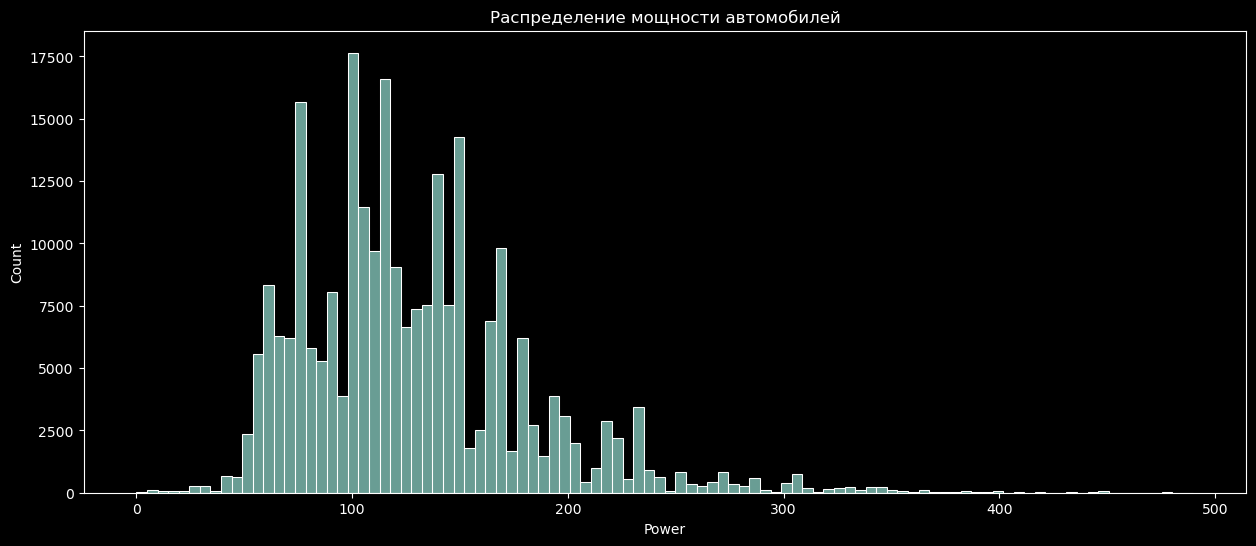

In [40]:
plt.figure(figsize=(15, 6))
sns.histplot(df['Power'], bins=100);
plt.title('Распределение мощности автомобилей');

### Дубликаты

Обработаем дубликаты.

In [41]:
df.duplicated().sum()

4

In [42]:
df = df.drop_duplicates()
df.duplicated().sum()

0

При ознакомлении с данными, мы обнаружили аномалии в столбцах `Power`,  `RegistrationYear` и пропуски в столбцах `VehicleType`, `Gearbox`, `FuelType`, `Repaired`. Удилив аномалии и заменив пропуски самыми частыми значениями, мы сохраним данные и улучшим качество предсказаний наших моделей.

### One-Hot Encoding.

Удалим неинформативные признаки.

In [43]:
df = df.drop(['DateCrawled', 'DateCreated', 'NumberOfPictures', 'PostalCode', 
              'LastSeen', 'Reg_auto', 'Reg_form', 'RegistrationMonth'], axis=1)
df.head(1)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
1,18300,coupe,2011,manual,190.0,other,125000,gasoline,audi,yes


Преобразуем категориальные признаки в численные методом One-Hot Encoding.

In [44]:
df = pd.get_dummies(df, drop_first=True)
df.head(2)

,Price,RegistrationYear,Power,Kilometer,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,...,Brand_skoda,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,Repaired_yes
1,18300,2011,190.0,125000,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,9800,2004,163.0,125000,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


Разобьем данные на обучающую, валидационную и тестовую выборки в соотношении 3:1:1

In [45]:
X_train, y_train, X_valid, y_valid, X_test, y_test = train_valid_test_split(df, target = 'Price',
                                                                            train_size=0.6, valid_size=0.2, 
                                                                            test_size=0.2, random_state=123)

Проверим размер выборок.

In [46]:
display(X_train.shape)
y_train.shape

(151058, 306)

(151058,)

In [47]:
display(X_valid.shape)
y_valid.shape

(50353, 306)

(50353,)

In [48]:
display(X_test.shape)
y_test.shape

(50353, 306)

(50353,)

### Масштабирование признаков

Произведем масштабирование признаков методом стандартизации данных.

In [49]:
X_train.head(2)

,RegistrationYear,Power,Kilometer,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,VehicleType_wagon,...,Brand_skoda,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,Repaired_yes
15192,2005,105.0,20000,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
46535,2006,75.0,150000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [50]:
# Численные признаки занесем в переменную
numeric = ['RegistrationYear', 'Power', 'Kilometer']

# Создание объекта для стандартизации данных
scaler = StandardScaler()
scaler.fit(X_train[numeric])

X_train[numeric] = scaler.transform(X_train[numeric])  # Масштабирование обучающего набора данных
X_valid[numeric] = scaler.transform(X_valid[numeric])  # Масштабирование валидационного набора данных
X_test[numeric] = scaler.transform(X_test[numeric])  # Масштабирование тестового набора данных

In [51]:
X_train.head()

,RegistrationYear,Power,Kilometer,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,VehicleType_wagon,...,Brand_skoda,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,Repaired_yes
15192,0.213406,-0.436379,-2.737517,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
46535,0.365447,-0.999428,0.642798,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
254223,-1.002918,-0.717903,0.642798,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
176837,-0.090675,0.276817,0.642798,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
185881,0.973609,-0.342537,0.642798,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


**Вывод**  
На данном этапе мы:
1. Ознакомились с данными;
2. Заполнили пропуски в столбцах `VehicleType`, `Gearbox`, `Model`, `FuelType`, `Repaired`;
3. Обработали аномальные значения в столбцах `RegistrationYear`, `Price`, `Power`;
4. Удалили дубликаты.
5. Разбили данные на обучающую, валидационную и тестовую выборки.
5. Преобразовали категориальные признаки в численные.
6. Произвели масштабирование признаков.

## Обучение моделей

### Линейная регрессия

In [52]:
%%time
lr = LinearRegression()
lr.fit(X_train, y_train)

CPU times: total: 15.1 s
Wall time: 6.07 s


LinearRegression()

In [53]:
%%time
lr_predictions = lr.predict(X_valid)

CPU times: total: 109 ms
Wall time: 137 ms


In [54]:
result = (mean_squared_error(y_valid, lr_predictions)) ** 0.5
print('RMSE модели линейной регрессии:', result)

RMSE модели линейной регрессии: 2772.234769416654


### Случайный лес

In [55]:
%%time

best_model_rf = None
best_result = 5000
best_estimators = 0
best_depth = 0

for depth in tqdm(range(5, 7, 1)):
    for estimators in [100, 200]:
        model = RandomForestRegressor(n_estimators=estimators, max_depth=depth, random_state=12345)
        model.fit(X_train, y_train)
        predictions_valid = model.predict(X_valid)
        score = mean_squared_error(y_valid, predictions_valid) ** 0.5
        
        if score < best_result:
            best_result = score
            best_depth = depth
            best_estimators = estimators
            best_model_rf = model

print('Лучшие гиперпараметры',
      'n_estimators:', best_estimators, 
      'max_depth:', best_depth, sep='\n')  
print('RMSE модели случайного леса:', best_result)  # 10 минут
print()

5
5
6
6
Лучшие гиперпараметры
n_estimators:
200
max_depth:
6
RMSE модели случайного леса: 2336.961277507033

CPU times: total: 18min 28s
Wall time: 19min 15s


### LightGBM

In [60]:
%%time

boosting_type = ['gbdt', 'goss']
max_depth = range(4, 7, 1)

best_score = 3000
best_model_light = None
best_depth = 0
best_type = None

for b in boosting_type:
    for depth in max_depth:
        lg = LGBMRegressor(boosting_type = b, max_depth=depth, n_jobs=-1, verbose=-1, random_state=123)
        lg.fit(X_train, y_train)
        lg_predictions = lg.predict(X_valid)
        lg_score = (mean_squared_error(y_valid, lg_predictions)) ** 0.5
        
        if lg_score < best_score:
            best_score = lg_score
            best_depth = depth
            best_type = b
            best_model_light = lg
            
print('Лучшие гиперпараметры',
      'Boosting_type:', best_type, 
      'max_depth:', best_depth, sep='\n')  
print('RMSE модели LightGBM', best_score)
print()

Лучшие гиперпараметры
Boosting_type:
gbdt
max_depth:
6
RMSE модели LightGBM 1833.2602815744142

CPU times: total: 38.1 s
Wall time: 12.1 s


**Вывод**  
На данном шаге мы рассмотрели 3 модели для решения задачи регрессии и подобрали гиперпараметры.

## Анализ моделей

Проанализируем время обучения, время предсказания и качество моделей на тестовой выборке.

### Линейная регрессия

In [61]:
%%time
lr.fit(X_train, y_train)

CPU times: total: 13.7 s
Wall time: 5.23 s


LinearRegression()

In [62]:
%%time
pred_test_lr = lr.predict(X_test)

CPU times: total: 125 ms
Wall time: 118 ms


In [63]:
score = (mean_squared_error(y_test, pred_test_lr)) ** 0.5
print ('RMSE на тестовой выборке для модели линейной регрессии:', score)

RMSE на тестовой выборке для модели линейной регрессии: 2790.041998612999


### Случайный лес

In [64]:
%%time
best_model_rf.fit(X_train, y_train)

CPU times: total: 6min 29s
Wall time: 6min 51s


RandomForestRegressor(max_depth=6, n_estimators=200, random_state=12345)

In [65]:
%%time
pred_test_rf = best_model_rf.predict(X_test)

CPU times: total: 750 ms
Wall time: 754 ms


In [66]:
score = (mean_squared_error(y_test, pred_test_rf)) ** 0.5
print ('RMSE на тестовой выборке для модели случайного леса:', score)

RMSE на тестовой выборке для модели случайного леса: 2360.09051220798


### LightGBM

In [67]:
%%time
best_model_light.fit(X_train, y_train)

CPU times: total: 5.11 s
Wall time: 1.42 s


LGBMRegressor(max_depth=6, n_jobs=-1, random_state=123, verbose=-1)

In [68]:
%%time
pred_test_light = best_model_light.predict(X_test)

CPU times: total: 688 ms
Wall time: 299 ms


In [69]:
score = (mean_squared_error(y_test, pred_test_light)) ** 0.5
print ('RMSE на тестовой выборке для модели LightGBM:', score)

RMSE на тестовой выборке для модели LightGBM: 1849.366494832024


### Проверка на адекватность

In [70]:
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(X_train, y_train)
dummy_pred = dummy_regr.predict(X_test)
print('RMSE константной модели:', (mean_squared_error(y_test, dummy_pred)) ** 0.5)

RMSE константной модели: 4532.935757734176


Качество нашей лучше модели выше качества константной модели.

**Вывод**  
Сравнив показатели мы определили, что лучшая скорость обучения у модели линейной регрессии.Но качество предсказаний не удовлетворяет критерию заказчика.У модели случайного леса хорошее качество, но низкая скорость обучения. Модель lightGBM подходит по всем параметрам.

## Общий вывод

В данном проекте мы выполнили следующие этапы:

1. Изучили дынные;
2. Обработали пропуски и аномальные значения;
3. Подготовили данные для обучения моделей;
4. Подобрали гиперпараметры для моделей линейной регрессии, случайного леса и LightGBM;
5. Проанализировали время обучения, время предсказания и качество моделей;
6. Определили модель, которая удовлетворяет требованиям заказчика - LightGBM. RMSE - `1849`.